###### Content under Creative Commons Attribution license CC-BY 4.0 version, by Enrique A. López-Guerra.

# Dynamic atomic force microscopy simulations over a viscoelastic material

This notebook contains atomic force microscopy (AFM) dynamic simulations for the case of a tapping mode simulation. In this example only the 1st eigenmode is excited, but you can easily modify it to excite up to three eigenmodes. The cantilever dynamics are assumed to be contained in the first three eigenmodes.

The simulation corresponds to the case of an AFM spherical tip interacting with a viscoelastic surface. The viscoelastic model is a generalized Maxwell model (Wiechert model) containing a large number of characteristic times. The contact mechanics have been implemented with respect to the classical theory of Lee and Radok: Lee, E. Ho, and Jens Rainer Maria Radok. "The contact problem for viscoelastic bodies." Journal of Applied Mechanics 27.3 (1960): 438-444.

### Let's first start by importing some useful libraries

In [1]:
from AFM_lib import GenMaxwell_LR
from AFM_calculations import Amp_Phase, E_diss, V_ts
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import pandas as pd
import os
%matplotlib inline

path = os.getcwd()

### Inserting simulation parameters

In [2]:
fo1, fo2, fo3 = 45.0e3, 280.0e3, 17.6*45.0e3 #eigenmodes' resonance frequencies
k_m1, k_m2, k_m3 = 5.80, 210.0, 5.80*(fo3/fo1) #1st eigenmode cantilever stiffness
A1, A2, A3 = 50.0e-9, 0.0, 0.0  #target oscillating free amplitude of the 1st three eigenmodes
Q1, Q2, Q3 = 167.0,340.0, 500.0 #quality factor of the 1st three eigenmodes
          
R = 10.0e-9 #tip radius

period1, period2 = 1.0/fo1, 1.0/fo2 #oscillating period of first two eigenmodes

dt = period1/50.0e3 #simulation timestep
startprint = 3.0*Q1*period1 #starting point when results will start to get printed
simultime = startprint + 25.0*period1 #total simulation time
printstep = dt*10.0 #how often the results will be stored

### OPTIONAL: Pulling sample parameters corresponding to Polyisobutylene (data obtained from: Brinson, Hal F., and L. Catherine Brinson. "Polymer engineering science and viscoelasticity." An Introduction (2008).) 

### If you want to use this model, you should place this and the following cell right before the cell labeled as Main portion of the simulation.

In [3]:
#Sample parameters for polyisobutylene
df_G = pd.read_csv('PIB.txt', delimiter='\t', header=None)
tau = df_G.iloc[:,0].values  #relaxation times of the generalized Maxwell model
G = df_G.iloc[:,1].values #moduli of the springs in the Maxwell arms 
Ge = 0.0 #equilibrium modulus (rubbery modulus)
H = 5.0e-19 #Hammaker constant

### Defining sample parameters: a simple model with two relaxation times

In [4]:
G = np.array([1.0e9,1.0e7]) #moduli of the springs in the Maxwell arms
tau = np.array([1.0/fo1/10.0,1.0/fo1]) #relaxation times of the generalized Maxwell model
Ge = 2.0e8 #equilibrium modulus (rubbery modulus)
H = 5.0e-19 #Hammaker constant


## Main portion of the simulation

The simulations described correspond to dynamic AFM spectroscopy simulations. Here, the cantilever will be brought towards the sample approaching with discrete steps and will be allowed to oscillate until achieving a quasi-steady state. From the tip trajectories and other information recoreded (e.g., tip-sample force, sample position) in the steady state it will be possible to retrieve common information recorded in a dynamic spectroscopy experiment (e.g., amplitude, phase curves).

In [5]:
zb = A1*1.1
GenMaxwell_jit = jit()(GenMaxwell_LR)

zeq = []
peakF = []
maxdepth = []
amp = []
phase = []
Ediss = []
Vdiss = []

t_a = []
tip_a = []
Fts_a = []
xb_a = []

while zb > 0.0:
    %time t, tip, Fts, xb = GenMaxwell_jit(G, tau, R, dt, startprint, simultime, fo1, fo2, fo3, k_m1, k_m2,k_m3, A1, A2, A3, zb, printstep, Ge, Q1, Q2, Q3, H)
    A,phi = Amp_Phase(t, tip, fo1)
    Ets = E_diss(tip, Fts, dt, fo1)
    fts_peak = Fts[np.argmax(Fts)]
    tip_depth = xb[np.argmax(tip)] -xb[np.argmin(tip)]
    Vts = V_ts(tip-zb, Fts, dt)
    
    #Attaching values to arrays
    zeq.append(zb)
    peakF.append(fts_peak)
    maxdepth.append(tip_depth)
    amp.append(A)
    phase.append(phi)
    Ediss.append(Ets)
    Vdiss.append(Vts)
    
    t_a.append(t)
    tip_a.append(tip)
    Fts_a.append(Fts)
    xb_a.append(xb)
    
    zb -= A1*0.05

zeq = np.array(zeq)
peakF= np.array(peakF)
maxdepth = np.array(maxdepth)
amp = np.array(amp)
phase = np.array(phase)
Ediss = np.array(Ediss)
Vdiss = np.array(Vdiss)

Wall time: 6.87 s
Wall time: 4.67 s
Wall time: 4.68 s
Wall time: 7.52 s
Wall time: 7.87 s
Wall time: 8.05 s
Wall time: 8.18 s
Wall time: 8.27 s
Wall time: 8.38 s
Wall time: 8.44 s
Wall time: 8.52 s
Wall time: 8.61 s
Wall time: 8.69 s
Wall time: 8.7 s
Wall time: 8.74 s
Wall time: 8.8 s
Wall time: 8.83 s
Wall time: 8.92 s
Wall time: 8.97 s
Wall time: 9 s
Wall time: 9.12 s
Wall time: 9.12 s


### Plotting dynamic spectroscopy curves (Amplitude, Phase approach curves)

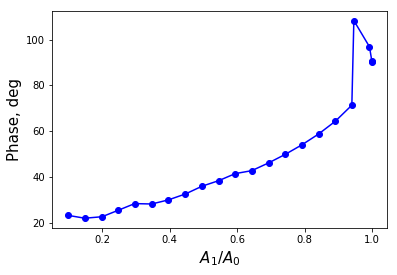

In [6]:
plt.plot(amp/A1, phase,'-o', color ='b')
plt.xlabel('$A_1/A_0$', fontsize =15)
plt.ylabel('Phase, deg', fontsize=15)

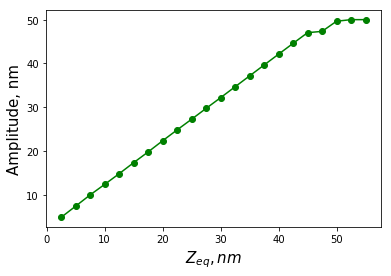

In [7]:
plt.plot(zeq*1.0e9, amp*1.0e9,'-o', color ='g')
plt.xlabel('$Z_{eq}, nm$', fontsize =15)
plt.ylabel('Amplitude, nm', fontsize=15)

## Plotting a typical force-distance curve

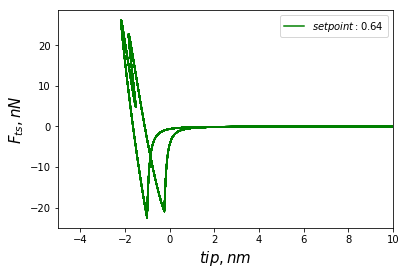

In [23]:
N = 10
setpoint = amp[N]/A1
plt.plot(tip_a[N]*1.0e9, Fts_a[N]*1.0e9, color ='g', label = '$setpoint: %.2f$'%setpoint)
plt.legend(loc='best')
plt.xlabel('$tip, nm$', fontsize =15)
plt.xlim(-5,10)
plt.ylabel('$F_{ts}, nN$', fontsize=15)

## Plotting the tip trajectory

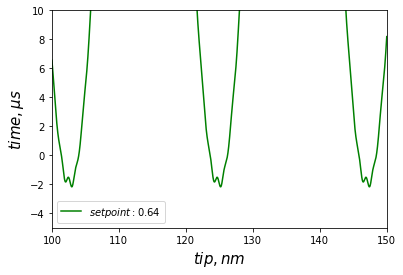

In [24]:
N = 10
setpoint = amp[N]/A1
plt.plot(t_a[N]*1.0e6, tip_a[N]*1.0e9, color ='g', label = '$setpoint: %.2f$'%setpoint)
plt.legend(loc='best')
plt.xlim(100,150)
plt.ylim(-5,10)
plt.xlabel('$tip, nm$', fontsize =15)
plt.ylabel('$time, \mu s$', fontsize=15)

## Plotting more results

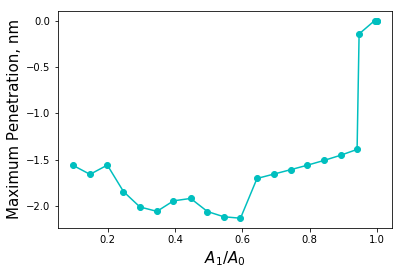

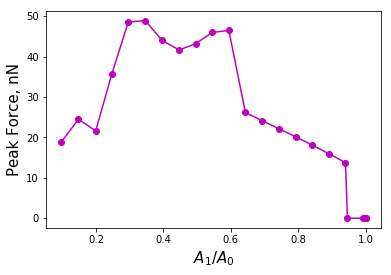

In [17]:
plt.figure(1)
plt.plot(amp/A1, -maxdepth*1.0e9,'-o', color ='c')
plt.xlabel('$A_1/A_0$', fontsize =15)
plt.ylabel('Maximum Penetration, nm', fontsize=15)
#plt.savefig('Max_penetration.png', bbox_inches='tight') #optional to save the figure in current path

plt.figure(2)
plt.plot(amp/A1, peakF*1.0e9,'-o', color ='m')
plt.xlabel('$A_1/A_0$', fontsize =15)
plt.ylabel('Peak Force, nN', fontsize=15)
#plt.savefig('Max_Force.png', bbox_inches='tight')  #optional line to save the figure in current path